# Test Gaussian fits to MCMC chains


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import optimize
from lace_manager.sampler import emcee_sampler
from lace_manager.likelihood import marg_p1d_like

### Load a sampler object, and plot posteriors

In [2]:
rootdir='/Users/font/Projects/LaCE_manager/lace_manager/sampler/chains/'

In [3]:
sampler=emcee_sampler.EmceeSampler(read_chain_file=6,
                                subfolder=None,rootdir=rootdir,
                                train_when_reading=True,
                                verbose=True)

will read chain from file 6
Building archive
Setting up emulator
Loading emulator using a specific archive, not the one set in basedir
Rescaled params to unity volume
Training GP on 330 points


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.22 seconds
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00
Setting up likelihood
Load sampler data


will keep 26536 \ 27400 points from chain


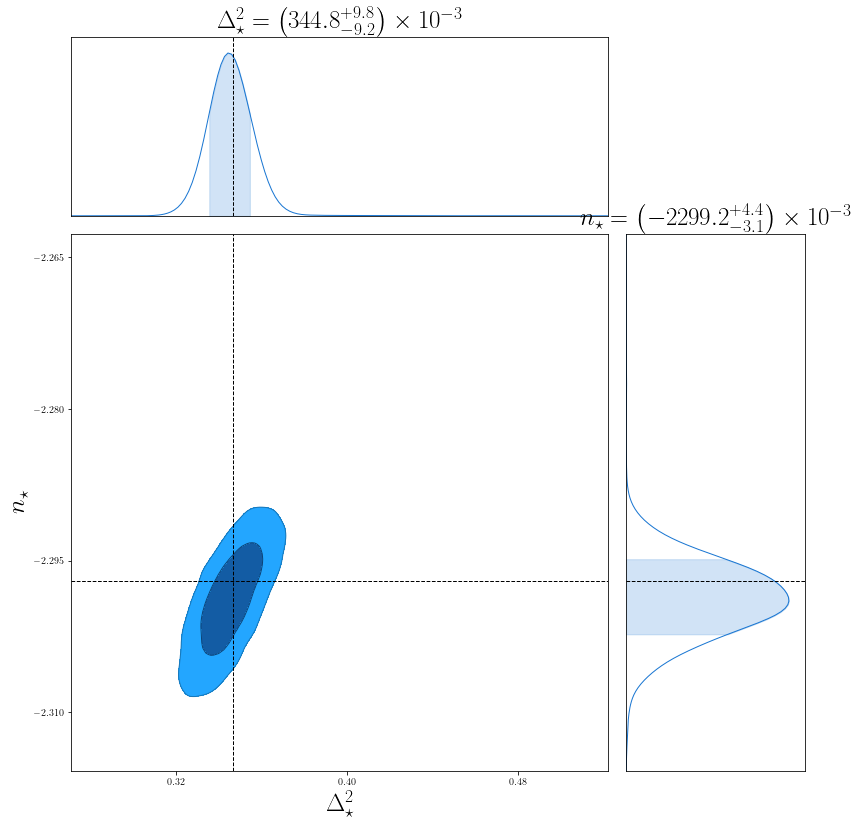

In [4]:
#plot_params=['$A_s$','$n_s$','$\Delta^2_\star$','$n_\star$']
plot_params=['$\Delta^2_\star$','$n_\star$']
sampler.plot_corner(delta_lnprob_cut=100,plot_params=plot_params)

# Play around with the chain

Derived statistics (mean, median, rms, MAD, etc.) will depend on how aggressively we remove the islands

In [5]:
# remove low-probability islands
delta_lnprob_cut=None
chain,lnprob,blobs=sampler.get_chain(cube=False,delta_lnprob_cut=delta_lnprob_cut)
max_lnprob=np.max(lnprob)
prob=np.exp(lnprob-max_lnprob)
x=blobs['Delta2_star']
y=blobs['n_star']

### Compute mean, covariance

In [6]:
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
print('{:.3f} < Delta2_star < {:.3f}'.format(xmin,xmax))
print('{:.3f} < n_star < {:.3f}'.format(ymin,ymax))

0.175 < Delta2_star < 0.600
-2.360 < n_star < -2.222


In [7]:
mean_D2_star=np.mean(x)
mean_n_star=np.mean(y)
print('Delta2_star (mean) =',mean_D2_star)
print('n_star (mean) =',mean_n_star)

Delta2_star (mean) = 0.3448272629469949
n_star (mean) = -2.2996239749489362


In [8]:
rms_D2_star=np.std(x)
rms_n_star=np.std(y)
print('Delta2_star (rms) =',rms_D2_star)
print('n_star (rms) =',rms_n_star)
cov=np.cov(x,y)
invcov=np.linalg.inv(cov)

Delta2_star (rms) = 0.017725663159434035
n_star (rms) = 0.00825724971755816


### Compute media and MAD, more robust to outliers

In [9]:
med_D2_star=np.median(x)
med_n_star=np.median(y)
print('Delta2_star (median) =',med_D2_star)
print('n_star (median) =',med_n_star)

Delta2_star (median) = 0.3449170935313542
n_star (median) = -2.29886571602826


In [10]:
std_mad_D2_star=1.4826*stats.median_abs_deviation(x)
std_mad_n_star=1.4826*stats.median_abs_deviation(y)
print('Delta2_star (std_mad) =',std_mad_D2_star)
print('n_star (std_mad) =',std_mad_n_star)

Delta2_star (std_mad) = 0.00887226790632296
n_star (std_mad) = 0.003766166160831095


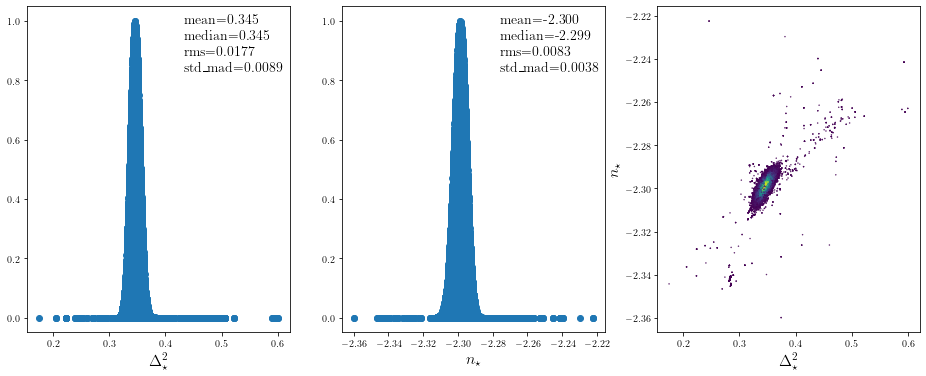

In [11]:
fig, axs = plt.subplots(1,3,figsize=(16,6),sharey=False)
axs[0].scatter(x,prob)
axs[0].set_xlabel(r'$\Delta^2_\star$',fontsize=16)
axs[0].annotate('mean={:.3f}'.format(mean_D2_star),xy=(0.6,0.95),xycoords='axes fraction',fontsize=14)
axs[0].annotate('median={:.3f}'.format(med_D2_star),xy=(0.6,0.9),xycoords='axes fraction',fontsize=14)
axs[0].annotate('rms={:.4f}'.format(rms_D2_star),xy=(0.6,0.85),xycoords='axes fraction',fontsize=14)
axs[0].annotate('std_mad={:.4f}'.format(std_mad_D2_star),xy=(0.6,0.8),xycoords='axes fraction',fontsize=14)
axs[1].scatter(y,prob)
axs[1].set_xlabel(r'$n_\star$',fontsize=16)
axs[1].annotate('mean={:.3f}'.format(mean_n_star),xy=(0.6,0.95),xycoords='axes fraction',fontsize=14)
axs[1].annotate('median={:.3f}'.format(med_n_star),xy=(0.6,0.9),xycoords='axes fraction',fontsize=14)
axs[1].annotate('rms={:.4f}'.format(rms_n_star),xy=(0.6,0.85),xycoords='axes fraction',fontsize=14)
axs[1].annotate('std_mad={:.4f}'.format(std_mad_n_star),xy=(0.6,0.8),xycoords='axes fraction',fontsize=14)
axs[2].scatter(x,y,c=prob,s=0.2)
axs[2].set_xlabel(r'$\Delta^2_\star$',fontsize=16)
axs[2].set_ylabel(r'$n_\star$',fontsize=16);
plt.savefig('hist_{}.png'.format(delta_lnprob_cut))

# Derive a robust Gaussian fit 

In [12]:
def get_correlation(delta_lnprob_cut=20):
    cut_lnprob=max_lnprob-delta_lnprob_cut
    mask=lnprob>cut_lnprob
    x=blobs['Delta2_star'][mask]
    y=blobs['n_star'][mask]
    return np.corrcoef(x,y)

In [13]:
# check that correlation coefficient is robust
print('cut -> corr coeff')
for cut in [5,20,50,100,500]:
    corr=get_correlation(cut)
    print('{} -> {:.3f}'.format(cut,corr[0,1]))

cut -> corr coeff
5 -> 0.756
20 -> 0.752
50 -> 0.746
100 -> 0.774
500 -> 0.831


In [14]:
def fit_gaussian(median_delta_lnprob_cut=50, corr_delta_lnprob_cut=20):
    # get correlation matrix using points only near the peak
    corr=get_correlation(corr_delta_lnprob_cut)
    # use more points to compute the median and MAD
    cut_lnprob=max_lnprob-median_delta_lnprob_cut
    mask=lnprob>cut_lnprob
    x=blobs['Delta2_star'][mask]
    y=blobs['n_star'][mask]
    # compute (robust) mean and std
    mean=np.array([np.median(x),np.median(y)])
    #print('Delta2_star (median) =',mean[0])
    #print('n_star (median) =',mean[1])
    # estimate rms with MAD
    rms_x=1.4826*stats.median_abs_deviation(x)
    rms_y=1.4826*stats.median_abs_deviation(y)
    #print('Delta2_star (std_mad) =',rms_x)
    #print('n_star (std_mad) =',rms_y)
    # scale covariance with correlation matrix
    rms=np.array([rms_x,rms_y])
    cov=(rms*corr).transpose()*rms
    return mean, cov

In [15]:
# check that estimation of mean via median is robust
print('cut -> param_median')
for cut in [20, 50, 100, 500]:
    mean,cov=fit_gaussian(median_delta_lnprob_cut=cut)
    print('{} -> {:.4f}, {:.4f}'.format(cut,mean[0],mean[1]))

cut -> param_median
20 -> 0.3451, -2.2988
50 -> 0.3451, -2.2988
100 -> 0.3451, -2.2988
500 -> 0.3450, -2.2988


In [16]:
# check that estimation of rms via MAD is robust
print('cut -> param_rms')
for cut in [20, 50, 100, 500]:
    mean,cov=fit_gaussian(median_delta_lnprob_cut=cut)
    rms=np.sqrt(cov.diagonal())
    print('{} -> {:.4f}, {:.4f}'.format(cut,rms[0],rms[1]))

cut -> param_rms
20 -> 0.0084, 0.0036
50 -> 0.0085, 0.0036
100 -> 0.0085, 0.0036
500 -> 0.0088, 0.0037


# Compare chain and Gaussian fit 

In [17]:
# actual Gaussian fit to use
mean,cov=fit_gaussian(median_delta_lnprob_cut=50)
invcov=np.linalg.inv(cov)

In [18]:
def gauss_log_like(D2_star,n_star,mean,invcov):
    diff=np.array([D2_star-mean[0],n_star-mean[1]])
    return -0.5*np.dot(np.dot(invcov,diff),diff)

In [19]:
# setup 2D grid
N=500
Nj=complex(0,N)
X, Y = np.mgrid[xmin:xmax:Nj, ymin:ymax:Nj]
# evaluate likelihood in 2D grid
log_like=np.array([gauss_log_like(D2,n,mean,invcov) for (D2,n) in zip(X.ravel(),Y.ravel())]).reshape(X.shape)
like=np.exp(log_like)

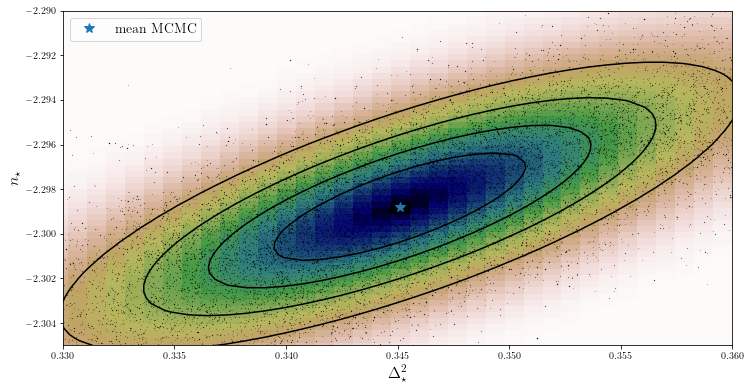

In [20]:
fig, ax = plt.subplots(1, 1,figsize=(12,8))
ax.imshow(np.rot90(like),cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])
ax.contour(X,Y,like,5,colors='k')
ax.plot(x, y, 'k.', markersize=0.2)
ax.plot(mean[0],mean[1],'*',markersize=10,label='mean MCMC')
ax.set_xlim(0.33,0.36)
ax.set_ylim(-2.305,-2.29)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\Delta^2_\star$',fontsize=16)
ax.set_ylabel(r'$n_\star$',fontsize=16);
plt.show()